# Chapter 2: The Technical Foundations of Text-Only RAG

**From Zero to Hero: Build a Retrieval-Augmented Generation from Scratch**

---

*Links:*
- *Read [Chapter 2 blog](https://medium.com/@marcharaoui/chapter-2-the-technical-foundations-of-text-only-rag-3e462eb5307e)*
- *Code repository on [github](https://github.com/marcharaoui/RAG-from-scratch/tree/main/chapter2)*

*Author:*

Marc Haraoui

[LinkedIn](https://www.linkedin.com/in/marc-haraoui/) | [GitHub](https://github.com/marcharaoui) | [X](https://x.com/marcharaoui) | [Hugging Face](https://huggingface.co/MarcHaraoui) | [Medium](https://medium.com/@marcharaoui)

---

Welcome to the Chapter 2 Notebook! 🎉

This notebook serves as a hands-on guide for building a text-based RAG pipeline, aligning with the concepts discussed in Chapter 2, as shown here:



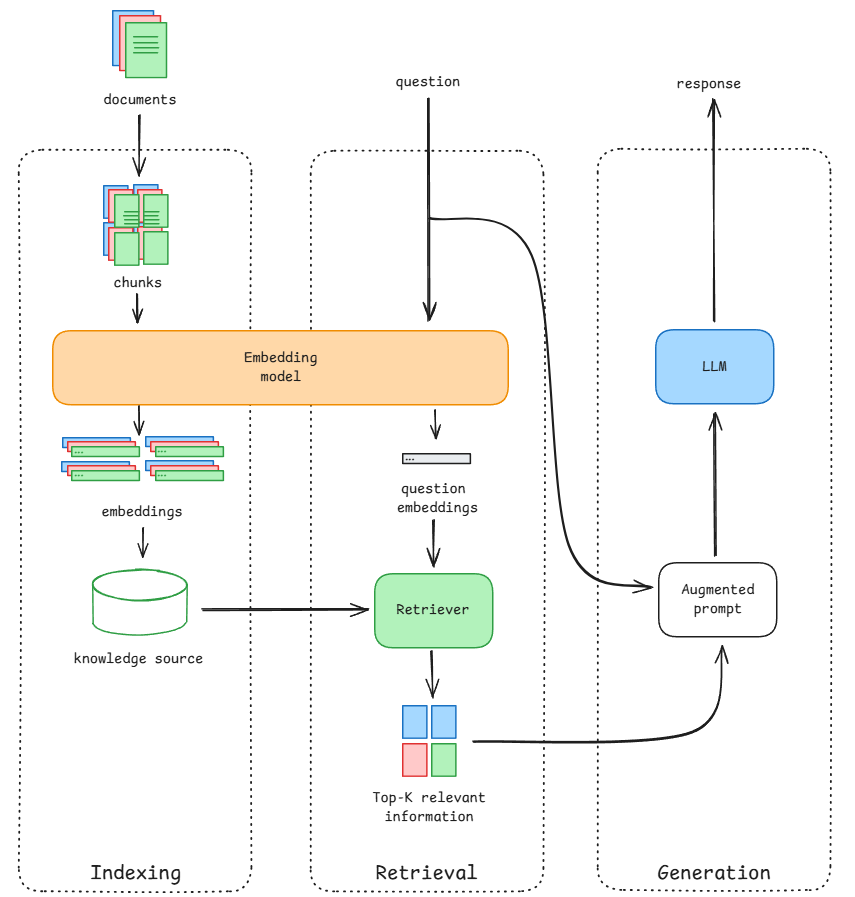



The goal is to provide a practical implementation that demonstrates how to combine retrieval techniques with language model generation for more accurate and context-aware responses.


Let’s get started! Happy coding🚀

*P.S. this notebook could be updated and improved over time*

## Setup

Start by installing and importing the required packages.

In this notebook we will focus on creating a functional RAG pipeline from scratch only. Keep it clear and open for you to understand.

In [6]:
!pip install sentence-transformers transformers scikit-learn

In [23]:
from typing import List, Dict
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
import transformers
import numpy as np
import sklearn
import torch
import os


Versions used for this notebook:

```
Python 3.11.11
Pytorch version 2.5.1+cu121
Numpy version 1.26.4
Transformers version 4.47.1
Scikit-learn version 1.6.1
```

Check yours:


In [24]:
!python --version
print(f"Pytorch version {torch.__version__}")
print(f"Numpy version {np.__version__}")
print(f"Transformers version {transformers.__version__}")
print(f"Scikit-learn version {sklearn.__version__}")

Python 3.11.11
Pytorch version 2.5.1+cu121
Numpy version 1.26.4
Transformers version 4.47.1
Scikit-learn version 1.6.1


## Creating the RAG system

For this demo, we'll be using MiniLM for the text encoder (using sentence-transformers to transform text to 384 dimensionally dense vectors), and SmolLM2, a small language model by Hugging Face, for the generator model.

In [44]:
class TextRAGPipeline:
    """
    A class to build a basic text-based RAG pipeline from scratch.

    Core functionality:
    1. Chunking text into smaller, retrievable pieces.
    2. Embedding text chunks for vector-based retrieval.
    3. Retrieving relevant chunks based on query similarity.
    4. Generating responses augmented by retrieved context.
    """

    def __init__(self, embedding_model: str = "all-MiniLM-L6-v2", generator_model: str = "meta-llama/Llama-3.3-70B-Instruct"):
        """
        Initialize the RAG pipeline.

        Args:
            embedding_model (str): Pretrained SentenceTransformer model for text embeddings.
            generator_model (str): Pretrained HuggingFace model for text generation.
        """
        # Load embedding model
        self.embedding_model = SentenceTransformer(embedding_model)

        # Load text generation model
        self.generator = pipeline(
            "text-generation",
            model=generator_model,
            model_kwargs={"torch_dtype": torch.bfloat16},
            device_map="auto",
        )

        # Storage for indexed data
        self.index      = []
        self.embeddings = []

    def chunk_text(self, text: str, chunk_size: int = 300, overlap: int = 50) -> List[str]:
        """
        Split text into smaller chunks for indexing.

        Args:
            text (str): The full document to chunk.
            chunk_size (int): Number of characters in each chunk.
            overlap (int): Number of overlapping characters between chunks.

        Returns:
            List[str]: A list of text chunks.
        """
        chunks = []
        start = 0
        while start < len(text):
            end = min(start + chunk_size, len(text))
            chunks.append(text[start:end])
            start += chunk_size - overlap
        return chunks

    def index_documents(self, documents: List[Dict[str, str]]):
        """
        Index a collection of documents by embedding their chunks and storing the results.

        Args:
            documents (List[Dict[str, str]]): A list of dictionaries with "id" and "text" keys.
        """
        for doc in documents:
            doc_id = doc["id"]
            text = doc["text"]
            chunks = self.chunk_text(text)
            chunk_embeddings = self.embedding_model.encode(chunks)

            for chunk, embedding in zip(chunks, chunk_embeddings):
                self.index.append({"id": doc_id, "chunk": chunk})
                self.embeddings.append(embedding)

        self.embeddings = np.array(self.embeddings)  # Convert to numpy array for efficiency

    def retrieve_chunks(self, query: str, top_k: int = 3) -> List[Dict[str, str]]:
        """
        Retrieve the top-k most relevant chunks for a query.

        Args:
            query (str): The search query.
            top_k (int): Number of chunks to retrieve.

        Returns:
            List[Dict[str, str]]: A list of top-k relevant chunks with their IDs and text.
        """
        # Compute the query embedding
        query_embedding = self.embedding_model.encode([query])
        # Compute cosine similarity between query and document embeddings
        similarities = cosine_similarity(query_embedding, self.embeddings)[0]
        # Get the indices of the top-k most similar chunks
        top_indices = np.argsort(similarities)[::-1][:top_k]

        # Retrieve and return the corresponding chunks
        retrieved_chunks = [{"id": self.index[i]["id"], "chunk": self.index[i]["chunk"], "score": similarities[i]}
                            for i in top_indices]
        return retrieved_chunks

    def generate_response(self, query: str, retrieved_chunks: List[Dict[str, str]], instructions: str = "You are a chat assistant who answers briefly using only the provided context.") -> str:
        """
        Generate a response to the query using retrieved chunks as context.

        Args:
            query (str): The user query.
            retrieved_chunks (List[Dict[str, str]]): Contextual chunks retrieved for the query.

        Returns:
            str: The generated response.
        """

        # Combine the retrieved chunks into a single context string
        context = " ".join([chunk["chunk"] for chunk in retrieved_chunks])

        # Construct the prompt for the language model
        prompt = f"Context: {context}\n\nQuestion: {query}:"

        # Prepare the augmented prompt
        augmented_prompt = [
            {"role": "system", "content": instructions},
            {"role": "user", "content": prompt},
        ]

        # Generate the response
        response = self.generator(augmented_prompt, max_new_tokens=256)

        return response[0]["generated_text"][-1]



### Preparing and loading the data

__Indexing__ is an offline task, meaning it is done ahead of time. This allows you to quickly look up relevant information at query-time.

When the user sends a query, the goal is to retrieve relevant documents, combine them with the query and specific instructions, and have the LLM generate a tailored answer in natural language.



Here is a small set of documents about AI startups that we will use to create an embedding database. To keep this demo simple, we will be using 3 small documents. But please note that this can be scaled with bigger documents and more of them.

F.y.i: The texts are taken from Wikipedia for this demo.

In [43]:
# Build the knowledge base
DOC_0 = "Cohere Inc. is a Canadian multinational technology company focused on artificial intelligence for the enterprise, specializing in large language models. Cohere was founded in 2019 by Aidan Gomez, Ivan Zhang, and Nick Frosst, and is headquartered in Toronto and San Francisco, with offices in Palo Alto, London, and New York City."
DOC_1 = "Hugging Face, Inc. is an American company incorporated under the Delaware General Corporation Law and based in New York City that develops computation tools for building applications using machine learning. It is most notable for its transformers library built for natural language processing applications and its platform that allows users to share machine learning models and datasets and showcase their work."
DOC_2 = "OpenAI is an American artificial intelligence (AI) research organization founded in December 2015 and headquartered in San Francisco, California. As a leading organization in the ongoing AI boom, OpenAI is known for the GPT family of large language models [...]. Its release of ChatGPT in November 2022 has been credited with catalyzing widespread interest in generative AI."

documents = [
    {
        "id": "0",
        "text": DOC_0,
    },
    {
        "id": "1",
        "text": DOC_1,
    },
    {
        "id": "2",
        "text": DOC_2,
    },

]

Now let's setup the RAG system and add the documents to its knowledge base.

In [29]:
rag = TextRAGPipeline(embedding_model="all-MiniLM-L6-v2", generator_model="HuggingFaceTB/SmolLM2-360M-Instruct")
rag.index_documents(documents)


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/724M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

Device set to use cpu


## Test the RAG system



### Preparing our inputs
Let's test out the system by providing different queries.

In [30]:
# Test text queries
queries = [
    "Which company is known for building the GPT family?",
    "What is Cohere's nationality?",
    "Which library is Hugging Face known for?",
]

### Retrieve relevant chunks

We are going to test out the system with 3 different examples.

What is the expected answer for each input:

1.   System will output: DOC_2 (OpenAI)
2.   System will output: DOC_0 (Cohere)
3.   System will output: DOC_1 (Hugging Face)



In [38]:
contexts = []
for query in queries:
    # Retrieve relevant chunks
    context = rag.retrieve_chunks(query, top_k=1)
    print("Query: ", query)
    print("Retrieved Chunk: ", context)
    contexts.append(context)

Query:  Which company is known for building the GPT family?
Retrieved Chunk:  [{'id': '2', 'chunk': 'OpenAI is an American artificial intelligence (AI) research organization founded in December 2015 and headquartered in San Francisco, California. As a leading organization in the ongoing AI boom, OpenAI is known for the GPT family of large language models [...]. Its release of ChatGPT in November 20', 'score': 0.32850534}]
Query:  What is Cohere's nationality?
Retrieved Chunk:  [{'id': '0', 'chunk': 'Cohere Inc. is a Canadian multinational technology company focused on artificial intelligence for the enterprise, specializing in large language models. Cohere was founded in 2019 by Aidan Gomez, Ivan Zhang, and Nick Frosst, and is headquartered in Toronto and San Francisco, with offices in Palo Alt', 'score': 0.6132046}]
Query:  Which library is Hugging Face known for?
Retrieved Chunk:  [{'id': '1', 'chunk': 'Hugging Face, Inc. is an American company incorporated under the Delaware General

### Generate an answer

We are going to test out the system with the same examples.

In [41]:
for i in range(len(queries)):
    # Generate a response using the retrieved chunks
    response = rag.generate_response(queries[i], contexts[i])
    print("Query: ", queries[i])
    print("Generated Response:", response['content'], "\n")


Query:  Which company is known for building the GPT family?
Generated Response: OpenAI is known for building the GPT family of large language models. 

Query:  What is Cohere's nationality?
Generated Response: Cohere Inc. is a Canadian multinational technology company focused on artificial intelligence for the enterprise, specializing in large language models. Cohere was founded in 2019 by Aidan Gomez, Ivan Zhang, and Nick Frosst, and is headquartered in Toronto and San Francisco, with offices in Palo Alto. 

Query:  Which library is Hugging Face known for?
Generated Response: Hugging Face is known for its transformers library, which is built for natural language processing applications. 



What if we asked a question that is not related to our documents? Well it depends on the instructions you give to the generator model.

Let's test this out and see!

In [49]:
instructions    = "You are a chat bot who only answers using the provided context. If the query isn't relevant to the context, respond with 'I don't know.'"
unrelated_query = "What is the capital of France?"

context  = rag.retrieve_chunks(unrelated_query, top_k=1)
response = rag.generate_response(unrelated_query, context, instructions=instructions)

print("Query: ", unrelated_query)
print("Generated Response:", response['content'], "\n")

Query:  What is the capital of France?
Generated Response: I don't know. 

